# Лабораторная работа №3 : Основы Tensorflow для построения нейронных сетей

Tensorflow (далее — TF) — довольно молодой фреймворк для глубокого машинного обучения, разрабатываемый в Google Brain. Долгое время фреймворк разрабатывался в закрытом режиме под названием DistBelief, но после глобального рефакторинга 9 ноября 2015 года был выпущен в open source. За год с небольшим TF дорос до версии 1.0, обрел интеграцию с keras, стал значительно быстрее и получил поддержку мобильных платформ. В последнее время фреймворк развивается еще и в сторону классических методов, и в некоторых частях интерфейса уже чем-то напоминает scikit-learn. До текущей версии интерфейс менялся активно и часто, но разработчики пообещали заморозить изменения в API. Мы будем рассматривать только Python API, хотя это не единственный вариант — также существуют интерфейсы для C++/C# и мобильных платформ.

## 1. Установка 
Для установки tensorflow рекомендуется использоваться pip, который устанавливается вместе с питоном. 
```
pip install tensorflow
```

## 2. Введение

Принципы работы с tensorflow достаточно просты. 
Мы должны составить граф операций, затем передать в этот граф данные и дать команду произвести вычисления. 
Для начала необходимо подключить необходимые библиотеки

In [4]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

C:\Users\axeli\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Для начала создадим простейший граф. 

Самым простейшим видом вершины в графе является константа. 
Для создания константного узла используется tf.constant(значение_константы). 

In [21]:
# константный узел графа, значение которого равно 5
a = tf.constant(5,tf.float32)

In [22]:
#Для запуска вычислений в части графа используется сессия.
#При использовании jupyter notebook рекомендуется использовать интерактивную сессию.
session = tf.InteractiveSession()

Для запуска вычислений для какой-либо части графа используется метод run. 

Он принимает два вида аргументов:
* Массив узлов, которые необходимо вычислить
* (не обязательно) Данные для графа. 
Передача данных графу будет рассмотрено позже. 

Функция возвращает массив вычисленных значений для каждого изла, переданного в первом параметре

Запустим вычисление простейшего графа, который на данный момент состоит из одной константной вершины

In [28]:
result = session.run(a)
result

5.0

для входных данных предусмотрен специальный тип placeholder
в отличии от константы он не требует указать значение заранее, но требует указать тип
также можно указать размерность и имя

In [40]:
b = tf.placeholder(tf.float32, shape=[])
# mult - узел, значение которого эквивалентно a*b , где a - константа объявленная выше
# b - узел, данные которого будут переданы при запуске вычислений
mult = tf.multiply(a,b)

In [41]:
# запустим вычисления для узла mult
# в качестве значения b передадим 5
mult_result = session.run(mult, { b : 5 } )
mult_result 

25.0

Ещё одним типом вершин является tf.Variable. Этот тип создан специально, чтобы изменять его значения во время вычислений. 
Именно он используется для весов и других мест, которые должны быть оптимизированы при обучении

In [32]:
# Для создания переменных узлов используется tf.get_variable
# в качестве параметров принимается имя, размерность и тип
var = tf.get_variable("example", shape = [1] , dtype=tf.float32)

При создании переменных они помещают в несколько коллекций : 
* tf.GraphKeys.GLOBAL_VARIABLES --- переменные, разделяемые между устройствами(GPU и CPU например). 
* tf.GraphKeys.TRAINABLE_VARIABLES --- Переменные, изменяемые при вычислениях. Например при градиентном спуске.

In [44]:
# вывод списка всех обучаемых переменных
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'example:0' shape=(1,) dtype=float32_ref>]

# 3. Построение простейшего нейрона
Заданием на данную лабораторную работу является построение простейшей модели с одним нейроном, которая будет 
предсказывать значение функции y = 2*a + 3b

In [18]:
# очистка графа
tf.reset_default_graph()
sess = tf.InteractiveSession()

Для начала необходимо сгенерировать исходные данные. 
Исходной функция содержит 2 переменные. 
Сгенерируем выборку 

In [19]:
dataset_size = 100

In [20]:
# Так как функция весьма проста, всю выборку можно сгенерировать в ручную

x = np.array([ [random.randint(1,10),random.randint(1,10)] for i in range(dataset_size)])
y = np.array( [ 2*x[i][0]+3*x[i][1] for i in range(dataset_size)]  )

In [21]:
# для каждого 0 < i < 100 2*a[i][0]+3*a[i][1] = y[i]
x[:5], y[:5]

(array([[ 4,  6],
        [ 5, 10],
        [ 5,  7],
        [ 8, 10],
        [10,  9]]), array([26, 40, 31, 46, 47]))

In [22]:
# создание узла для подачи данных
# в каждой записи исходной выборки содержится два параметра
# поэтому размер узла = [2,1]
x_input = tf.placeholder(tf.float32, shape=[2])
y_input = tf.placeholder(tf.float32, shape=[])

Были добавлены точки для входных данных
![asda](./images/lab32_1.png "Title")

In [23]:
# создание весов для
weights = tf.get_variable("weight", shape = [2] ,dtype=tf.float32)
bias = tf.get_variable("bias", shape = [2] ,dtype=tf.float32)

In [24]:
model = x_input * weights + bias
result = tf.reduce_sum(model)

В модель были добавлены веса. После подачи вектора из двух значений в x_input этот вектор сначала умножается на вектор weights, 
а затем складываются с вектором bias. 
Затем оба значения в векторе складываются.
![asda](./images/lab32_3.png "Title")
На данном этапе модель готова : она может предсказывать на основе исходных данных. Но данная модель не обучена. Добавим вычисление потерь и оптимизатор, который будет оценивать потери и изменять веса weight и bias 

In [35]:
# вычисление среднеквадратичной ошибки между result и y_input
loss = tf.losses.mean_squared_error(result, y_input)
# в качестве метода опитимизации - градиентный спуск
# для минимизации указываем потери, вычисленные раньше.
# Используя переданный оптимизатору граф, он находит переменные которые можно оптимизировать
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

Теперь граф выглядит следующим образом
![asda](./images/lab32_4.png "Title")

Общий принцип работы следующий:
* Подаются исходные значения a и b в виде вектора
* Вектор умножается и складывается с весами
* Вычисляется сумма значений вектора, это и есть результат
* Для результата вычисляются потери
* Оптимизатор, используя градиентный спуск, изменяет веса weight и bias для минимизации потерь. 

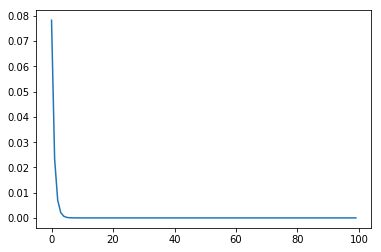

In [31]:
# сброс всех переменных в модели
tf.global_variables_initializer().run()
# количество итераций
# каждую итерацию модель обучается на полном наборе данных
# т.е. если dataset_size = 100, то суммарное кол-во 10000
iterations = 100


losts = []
# на каждой итерации
for i in range(iterations):
    # проводится обучения на всей выборке 
    last_step_loss = 0
    for j in range(dataset_size):
        # запуск оптимизатора. Так же получаем ошибку из графа
        last_step_loss , _  = sess.run([loss,optimizer], {x_input : x[j], y_input : y[j]})
    # запись ошибки в конце каждой итерации
    losts.append(last_step_loss)
#вывод ошибки на конец каждой итерации
plt.plot(range(len(losts)),losts)

Как видно из графика примерно на 10й итерации ошибка ровна нулю, так как исходная функция весьма простая. Можно добавить условие, которое проверяет ошибку и если она мала - заканчивает вычисления. 

Теперь наша модель готова и обучена, её веса оптимальны. При её использовании нет необходимости запускать оптимизатор, только вычисления результата. Таким образом вершина loss_function и optimizer не будут использоваться. Так как они не используются, передавать данные в y_input так же не нужно

In [33]:
test = sess.run([result],{x_input : [ 2, 3] })
test

[13.0]

Очевидно что модель, построенная выше является нейроном
![asda](./images/neuron.png "Title")


# Задание на лабораторную

Используя tensorflow построить модель, способную вычислять функцию :

| Вариант        | Функция     |
| -------------  |:-----------:|
| 1              | y=9a-8b       |
| 2              | y=3a-21b      |
| 3              | y=21a+4b      |
| 4              | y=2a-4b       |
| 5              | y=15a+3b      |
| 6              | y=5a-6b       |
| 7              | y=3a-4b       |
| 8              | y=13a-9b      |
| 9              | y=12a-8b      |
| 10             | y=5a+11b      |